In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis
import time
import scipy.stats


root = '/usr/local/serenceslab/maggie/shapeDim/'
sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils, plot_utils, stats_utils

In [12]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [13]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
    

In [14]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_binary_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

#### compute Checker Task accuracy for different sets of trials
Easy, Med, Hard are all in main grid, different positions relative to boundaries


In [16]:
conf_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

conf_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

conf_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

conf_hardtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_hardtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_hardtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

ii = 0;

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        dist_from_center = l['dist_from_center'].round(2)
        
        categ_actual = np.array(l['categ_task3']).astype(int)
        
        un_dist = np.unique(dist_from_center[is_main_grid])
        
        is_hard = is_main_grid & (dist_from_center==un_dist[0])
        is_medium = is_main_grid & (dist_from_center==un_dist[1])
        is_easy = is_main_grid & (dist_from_center==un_dist[2])
        
        correct = np.array(l['subject_correct'])
        
        for ri in range(n_rois):

            # switching categs here so that 1=coord<center, 2=coord>center
            categ_pred = 3-dec_withintask['preds_all'][si][ri][ti][2].astype(int)

            prob = dec_withintask['probs_all'][si][ri][ti][2]

            p_categ1 = prob[:,1]
            p_categ2 = prob[:,0]

            # signed confidence will be: p(correct) - p(incorrect)
            signedconf = np.zeros_like(p_categ1)
            signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
            signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]

            
            inds = is_main_grid & correct
                
            conf_allmaintrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_allmaintrials[si,ri,ti,ii] = d;

            acc_allmaintrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])

            # easy trials
            inds = is_easy & correct

            conf_easytrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_easytrials[si,ri,ti,ii] = d;

            acc_easytrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])

            # medium trials
            inds = is_medium & correct

            conf_medtrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_medtrials[si,ri,ti,ii] = d;

            acc_medtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])

            # hard trials
            inds = is_hard & correct
            
            conf_hardtrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_hardtrials[si,ri,ti,ii] = d;

            acc_hardtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])


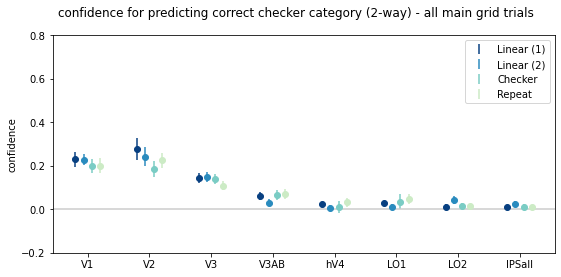

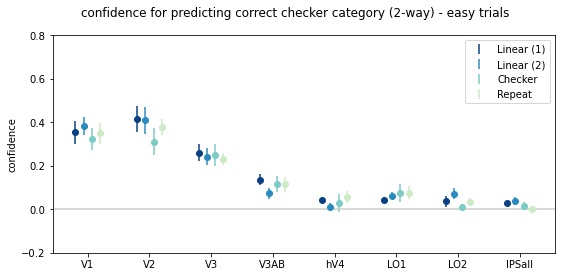

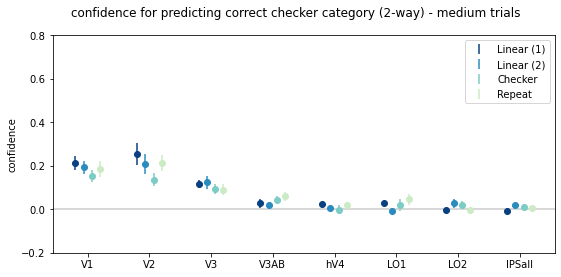

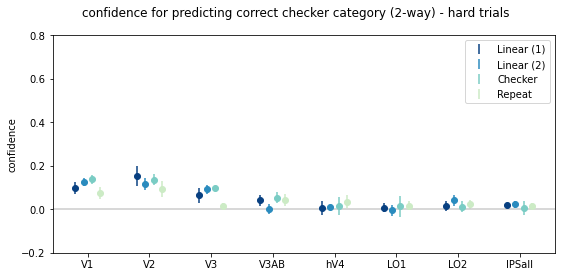

In [19]:
ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 4)

for rvals, name in zip([conf_allmaintrials, conf_easytrials, conf_medtrials, conf_hardtrials], \
                     ['all main grid trials', 'easy trials','medium trials', 'hard trials']):

    plt.figure(figsize=(9,4))

    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = rvals[:,:,ti,ii]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    plt.ylim([-0.2, 0.8])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.suptitle('confidence for predicting correct checker category (2-way) - %s'%name)


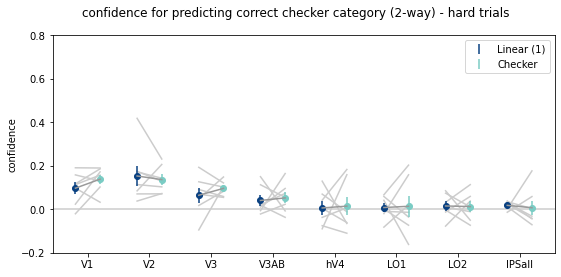

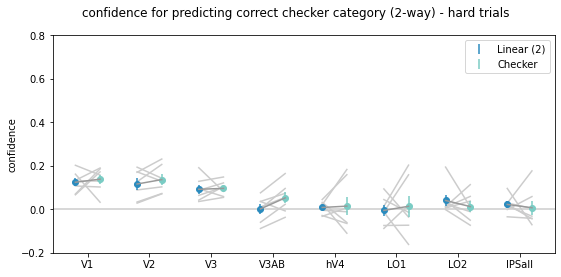

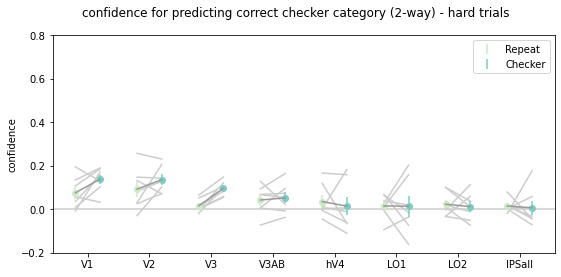

In [18]:
for ti_plot in [[0,2],[1,2],[3,2]]:


    x_jitter = np.linspace(-0.2, 0.2, 2)

    for rvals, name in zip([conf_hardtrials], \
                         ['hard trials']):

        plt.figure(figsize=(9,4))

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for tii, ti in enumerate(ti_plot):

            x_ticks = np.arange(n_rois) + x_jitter[tii]

            vals = rvals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)

        for ri in range(n_rois):

            meanvals = np.mean(rvals[:,ri,ti_plot,ii], axis=0)
            plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6])

            plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, color=[0.8, 0.8, 0.8], zorder=-10)


        plt.ylim([-0.2, 0.8])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('confidence')

        plt.legend(lh,np.array(task_names)[ti_plot])

        plt.suptitle('confidence for predicting correct checker category (2-way) - %s'%name)
